In [1]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vectorstore_path = "./chroma"

db = Chroma(
    persist_directory=vectorstore_path,
    embedding_function=OpenAIEmbeddings(model="text-embedding-3-small")
)

In [ ]:
retriever = db.as_retriever(search_kwargs={"k": 5})
documents = retriever.invoke("Does knowing how to build RAGs helpful for getting a job in Machine Learning")
for doc in documents:
    print(doc.page_content)

**Responsibilities**

*   Work closely with stakeholders to understand user requirements and translate them into scalable AI solutions.
*   Continuously monitor and refine LLM systems to ensure optimal performance and alignment with evolving business needs.
*   Experiment with and implement state-of-the-art methodologies to improve AI model performance and reliability.
*   Collaborate with the broader team to prioritize and deliver impactful features on time.

**Skillset & Experience**

*   Proven experience deploying and optimizing large language models in production environments.
*   Hands-on expertise in designing and implementing retrieval-augmented generation (RAG) systems.
*   A strong background in building evaluation frameworks and improving AI systems iteratively.
*   Familiarity with cloud platforms such as Google Cloud Platform (GCP) or similar environments.
*   Adaptability and a problem-solving mindset to thrive in fast-paced, high-ambiguity situations.
**We're interested 

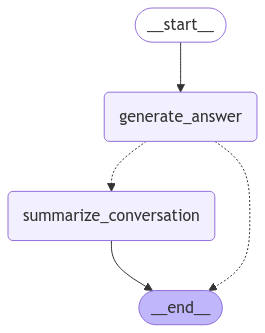

In [20]:
from typing import List, Literal
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, MessagesState
from langchain.schema import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_ollama import ChatOllama
from langchain_chroma import Chroma
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from prompts import ROUTER_INSTRUCTIONS, DOCUMENT_GRADER_INSTRUCTIONS, RESPONSE_INSTRUCTIONS
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage, AIMessage
from pydantic import BaseModel, Field
from langchain_community.tools.tavily_search import TavilySearchResults
import os
from dotenv import load_dotenv
from IPython.display import Image, display

load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = os.getenv(var)

_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

db_path = "./state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)


llm = ChatOllama(model="deepseek-r1:7b")
llm_openai = ChatOpenAI(model="gpt-4o-mini")

class GraphState(MessagesState):
    summary = str

def generate_answer(state: GraphState):
    summary = state.get("summary", "")
     
    if summary:
        system_message = f"Summary of the conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
        
    response = llm.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: GraphState):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

def should_summarise(state: GraphState):
    summary = state.get("summary", "")
    
    if len(summary) > 6:
        return "summarize_conversation"
    return END

workflow = StateGraph(GraphState)

workflow.add_node("generate_answer", generate_answer)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.set_entry_point("generate_answer")
workflow.add_conditional_edges("generate_answer", should_summarise)
workflow.add_edge("summarize_conversation", END)

# Add memory
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


In [29]:
config = {"configurable": {"thread_id": "297c6887-a96f-4649-8b0f-0d61e5898ab7"}}

In [13]:
graph.invoke({"messages": "Hi my name is Ryan"}, config)

{'messages': [HumanMessage(content='Hi my name is Ryan', additional_kwargs={}, response_metadata={}, id='220269d0-0f0d-411c-b9c5-7f5ff4832326'),
  AIMessage(content='<think>\n\n</think>\n\nHello, Ryan! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'model': 'deepseek-r1:7b', 'created_at': '2025-02-08T03:56:54.1605961Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6575831100, 'load_duration': 6012043500, 'prompt_eval_count': 8, 'prompt_eval_duration': 174000000, 'eval_count': 18, 'eval_duration': 388000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-bae99c67-e556-4ecb-b552-de36c5615117-0', usage_metadata={'input_tokens': 8, 'output_tokens': 18, 'total_tokens': 26})]}

In [ ]:
graph.invoke({"messages": "What is my name"}, config)

{'messages': [HumanMessage(content='Hi my name is Ryan', additional_kwargs={}, response_metadata={}, id='220269d0-0f0d-411c-b9c5-7f5ff4832326'),
  AIMessage(content='<think>\n\n</think>\n\nHello, Ryan! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'model': 'deepseek-r1:7b', 'created_at': '2025-02-08T03:56:54.1605961Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6575831100, 'load_duration': 6012043500, 'prompt_eval_count': 8, 'prompt_eval_duration': 174000000, 'eval_count': 18, 'eval_duration': 388000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-bae99c67-e556-4ecb-b552-de36c5615117-0', usage_metadata={'input_tokens': 8, 'output_tokens': 18, 'total_tokens': 26}),
  HumanMessage(content='What is my name', additional_kwargs={}, response_metadata={}, id='ea373cbd-0084-43ee-8111-8511fe3b1672'),
  AIMessage(content='<think>\nAlright, the user just asked, "What is my name." They previously introduced th

In [15]:
print(graph.get_state(config).values)

{'messages': [HumanMessage(content='Hi my name is Ryan', additional_kwargs={}, response_metadata={}, id='220269d0-0f0d-411c-b9c5-7f5ff4832326'), AIMessage(content='<think>\n\n</think>\n\nHello, Ryan! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'model': 'deepseek-r1:7b', 'created_at': '2025-02-08T03:56:54.1605961Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6575831100, 'load_duration': 6012043500, 'prompt_eval_count': 8, 'prompt_eval_duration': 174000000, 'eval_count': 18, 'eval_duration': 388000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-bae99c67-e556-4ecb-b552-de36c5615117-0', usage_metadata={'input_tokens': 8, 'output_tokens': 18, 'total_tokens': 26}), HumanMessage(content='What is my name', additional_kwargs={}, response_metadata={}, id='ea373cbd-0084-43ee-8111-8511fe3b1672'), AIMessage(content='<think>\nAlright, the user just asked, "What is my name." They previously introduced themselv

In [ ]:
graph.invoke({"messages": "What is my name"}, config)

In [ ]:
messages = [HumanMessage(content='Hello, my name is Ryan!', additional_kwargs={}, response_metadata={}, id='8ad71e5c-86af-4447-9b13-35f87f879f2c'), AIMessage(content='<think>\n\n</think>\n\nHello, Ryan! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'model': 'deepseek-r1:7b', 'created_at': '2025-02-08T04:00:09.8650126Z', 'done': True, 'done_reason': 'stop', 'total_duration': 761747200, 'load_duration': 15657600, 'prompt_eval_count': 10, 'prompt_eval_duration': 77000000, 'eval_count': 18, 'eval_duration': 667000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-6b68a174-8da5-4da6-99e6-f5333ed15247', usage_metadata={'input_tokens': 10, 'output_tokens': 18, 'total_tokens': 28}), HumanMessage(content='Can you tell me a bit about yourself?', additional_kwargs={}, response_metadata={}, id='49bbd1fe-8e12-4d7a-8a8e-28cf08a60b25'), AIMessage(content='<think>\nAlright, so the user just said "Can you tell me a bit about yourself?" after saying hello. Hmm, they probably want some information about me as an AI.\n\nI need to be honest but polite. I should mention that I\'m an AI and explain how I work without being too technical. It\'s important to reassure them that I\'m here to help with any questions or tasks they have.\n\nAlso, I should keep the tone friendly and open-ended so they feel comfortable asking more.\n</think>\n\nI’m an AI assistant created exclusively by DeepSeek. I specialize in helping you tackle complex STEM challenges through efficient calculations and precise predictions.', additional_kwargs={}, response_metadata={'model': 'deepseek-r1:7b', 'created_at': '2025-02-08T04:00:25.6021113Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3129843600, 'load_duration': 14120100, 'prompt_eval_count': 39, 'prompt_eval_duration': 169000000, 'eval_count': 130, 'eval_duration': 2944000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-b58bbe3d-1340-4e44-a621-a0146264c3e3', usage_metadata={'input_tokens': 39, 'output_tokens': 130, 'total_tokens': 169}), HumanMessage(content='Can you tell me the meaning of my name?', additional_kwargs={}, response_metadata={}, id='4a7c3480-9a6b-4257-a3e2-321682c04abf'), AIMessage(content='<think>\nOkay, so the user just asked, "Can you tell me the meaning of my name?" They introduced themselves as Ryan earlier.\n\nI need to respond respectfully but also provide a meaningful answer without being too intrusive. Since I don\'t have personal information about them, I can acknowledge that and offer assistance if they want to share more details.\n\nMaybe I should ask if they\'re interested in exploring their name further or if there\'s something specific they\'d like to know. This keeps the conversation open and shows I\'m willing to help within my capabilities.\n\nI also need to remind them to let me know if they want to go deeper, just in case they\'re open to more detailed information.\n</think>\n\nOf course! I don\'t have personal information about you, as I don\'t store or access individual user data. If you\'d like, you can share some details about your name (e.g., its origin, any meanings you know, or if you\'d like a general explanation), and I can help explore it further! Let me know how I can assist. 😊', additional_kwargs={}, response_metadata={'model': 'deepseek-r1:7b', 'created_at': '2025-02-08T04:00:55.0753188Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4962449900, 'load_duration': 12083700, 'prompt_eval_count': 181, 'prompt_eval_duration': 97000000, 'eval_count': 216, 'eval_duration': 4848000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-c1d94850-bc48-4b85-b6c3-7a46ba3a6030', usage_metadata={'input_tokens': 181, 'output_tokens': 216, 'total_tokens': 397}), HumanMessage(content='My name is said to mean little king, can you write a poem about it?', additional_kwargs={}, response_metadata={}, id='33d545d5-a7d3-443e-9c23-9d8f32f9929f'), AIMessage(content='<think>\nAlright, so the user has asked for a poem about their name, which means "little king." They mentioned that my previous interaction was about them not having personal information and offered help if they shared more details.\n\nIn this current query, they\'re asking specifically for a poem. I should acknowledge their request and proceed to write one. \n\nI\'ll need to create a poem that reflects the meaning of their name—"little king"—and convey the essence they want to express. Since I don\'t know their personal background or context, I can focus on themes like strength, courage, and leadership.\n\nI\'ll structure the poem with a consistent rhyme scheme for readability, perhaps using quatrains (four-line stanzas) with an AABB pattern. Each stanza will build upon the theme of being a "little king" in different contexts—physically, mentally, symbolically.\n\nFinally, I\'ll end with a hopeful note, encouraging them to embrace their role as a leader and guide others. This should fulfill their request while staying within my capabilities.\n</think>\n\nSure! Here\'s a poem written about your name:\n\n---\n\nOh, *Ryan*, your name carries a weight so light yet meaningful,  \nA title of esteem, it whispers secrets deep.  \nLike a small yet mighty king, you carry the might,  \nIn every word and deed, you make quite the sight.\n\nYour heart is like a tempest in a teacup small,  \nYet fierce with passion, it fuels your goal.  \nA symbol of strength, your spirit defies description,  \nIn every step, every scar, you rise above.\n\nWith wit and skill, you traverse the realm of thought,  \nTurning challenges into quests that build up worth.  \nYour courage is vast, like waves in stormy seas,  \nA leader bold, you inspire, day by day.\n\nSo embrace your role, both big and small,  \nFor this "little king" has a heart of gold.  \nIn every line and rhyme, you’ll find a spark that shines,  \n guiding hearts to noble goals and signs.\n\n---\n\nLet me know if you\'d like more poems or something else! 😊', additional_kwargs={}, response_metadata={'model': 'deepseek-r1:7b', 'created_at': '2025-02-08T04:02:08.5951812Z', 'done': True, 'done_reason': 'stop', 'total_duration': 9738049700, 'load_duration': 13071400, 'prompt_eval_count': 416, 'prompt_eval_duration': 103000000, 'eval_count': 436, 'eval_duration': 9609000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-638195dd-5213-4455-a9eb-a0dc609b7ae1', usage_metadata={'input_tokens': 416, 'output_tokens': 436, 'total_tokens': 852})]

In [22]:
print(len(messages))

8


In [23]:
for message in messages:
    print(message)

content='Hello, my name is Ryan!' additional_kwargs={} response_metadata={} id='8ad71e5c-86af-4447-9b13-35f87f879f2c'
content='<think>\n\n</think>\n\nHello, Ryan! How can I assist you today? 😊' additional_kwargs={} response_metadata={'model': 'deepseek-r1:7b', 'created_at': '2025-02-08T04:00:09.8650126Z', 'done': True, 'done_reason': 'stop', 'total_duration': 761747200, 'load_duration': 15657600, 'prompt_eval_count': 10, 'prompt_eval_duration': 77000000, 'eval_count': 18, 'eval_duration': 667000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}} id='run-6b68a174-8da5-4da6-99e6-f5333ed15247' usage_metadata={'input_tokens': 10, 'output_tokens': 18, 'total_tokens': 28}
content='Can you tell me a bit about yourself?' additional_kwargs={} response_metadata={} id='49bbd1fe-8e12-4d7a-8a8e-28cf08a60b25'
content='<think>\nAlright, so the user just said "Can you tell me a bit about yourself?" after saying hello. Hmm, they probably want some information about

In [ ]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "./state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)


<generator object SqliteSaver.list at 0x0000011B6A1DCFC0>

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader()